This method of cross validation (next sets consist of previous ones) causes model to perform worse after few runs.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("drive/MyDrive/Engineer's Project/test.csv")

In [ ]:
#df.pop('usa_cpi')
#df.pop('pol_cpi')
#df.pop('usa_inter')
#df.pop('pol_inter')
df.pop('Date')

In [ ]:
scaler = MinMaxScaler()
 
df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[
  'Opening', 'High', 'Low', 'Closing','Momentum', 'Range', 'ohlc','usa_cpi','pol_cpi', 'usa_inter', 'pol_inter'])

In [ ]:
df_scaled.head()

,Opening,High,Low,Closing,Momentum,Range,ohlc,usa_cpi,pol_cpi,usa_inter,pol_inter
0,0.120675,0.117873,0.126956,0.120667,0.690773,0.054192,0.119970,0.15359,0.34127,0.722973,0.911417
1,0.123241,0.121031,0.129086,0.123235,0.683946,0.060890,0.122587,0.15359,0.34127,0.722973,0.911417
2,0.142932,0.149455,0.131536,0.142949,0.611761,0.216769,0.140329,0.15359,0.34127,0.722973,0.911417
3,0.144181,0.147570,0.146659,0.144170,0.696958,0.119040,0.144171,0.15359,0.34127,0.722973,0.911417
4,0.125944,0.129385,0.130204,0.125935,0.690665,0.104427,0.126353,0.15359,0.34127,0.722973,0.911417


In [ ]:
std = df['Closing'].std()
std_scaled = df_scaled['Closing'].std()

In [ ]:
float_data = np.array(df_scaled).astype('float32')
#mean = float_data[:2501].mean(axis=0)
stdOld = float_data[:2501].std(axis=0)
stdOldWhole = float_data.std(axis=0)
#float_data -= mean
#float_data /= std
#stdOld
#stdOldWhole

In [ ]:
std_scaled

0.19873963078543957

In [ ]:
lookback = 10
step = 1
delay = 1
batch_size = 128

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=1):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
        min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][3] ##### HIT KURDE 1 to numer kolumny ktora przewiduje wtf
    yield samples, targets

In [ ]:
train_gen1 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=601,
shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen1 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=601,
max_index=801,
step=step,
batch_size=batch_size)

In [ ]:
test_gen1 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=801,
max_index=1001,
step=step,
batch_size=batch_size)

In [ ]:
val_steps1 = (801 - 601 - lookback)
test_steps1 = (1001 - 801 - lookback)

In [ ]:
train_gen2 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=1001,
shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen2 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=1001,
max_index=1201,
step=step,
batch_size=batch_size)

In [ ]:
test_gen2 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=1201,
max_index=1401,
step=step,
batch_size=batch_size)

In [ ]:
val_steps2 = (1201 - 1001 - lookback)
test_steps2 = (1401 - 1201 - lookback)

In [ ]:
train_gen3 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=1401,
shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen3 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=1401,
max_index=1601,
step=step,
batch_size=batch_size)

In [ ]:
test_gen3 = generator(float_data,
lookback=lookback,
delay=delay,
min_index=1601,
max_index=1801,
step=step,
batch_size=batch_size)

In [ ]:
val_steps3 = (1601 - 1401 - lookback)
test_steps3 = (1801 - 1601 - lookback)

In [ ]:
model1 = tf.keras.models.Sequential()
model1.add(layers.LSTM(128,
  activation='softmax',
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model1.add(layers.Dense(5,
  activation='softmax',))
model1.add(layers.Dense(1))
model1.compile(optimizer= tf.keras.optimizers.RMSprop(), loss='mae')
history1 = model1.fit(train_gen1,
  steps_per_epoch=400,
  epochs=80,
  validation_data=val_gen1,
  validation_steps=val_steps1)

Epoch 1/80
400/400 [==============================] - 26s 56ms/step - loss: 0.1071 - val_loss: 0.0236
Epoch 2/80
400/400 [==============================] - 22s 55ms/step - loss: 0.0570 - val_loss: 0.0402
Epoch 3/80
400/400 [==============================] - 23s 59ms/step - loss: 0.0255 - val_loss: 0.0239
Epoch 4/80
400/400 [==============================] - 23s 58ms/step - loss: 0.0234 - val_loss: 0.0184
Epoch 5/80
400/400 [==============================] - 24s 60ms/step - loss: 0.0224 - val_loss: 0.0160
Epoch 6/80
400/400 [==============================] - 22s 56ms/step - loss: 0.0218 - val_loss: 0.0146
Epoch 7/80
400/400 [==============================] - 21s 53ms/step - loss: 0.0214 - val_loss: 0.0155
Epoch 8/80
400/400 [==============================] - 21s 53ms/step - loss: 0.0211 - val_loss: 0.0147
Epoch 9/80
400/400 [==============================] - 23s 58ms/step - loss: 0.0209 - val_loss: 0.0148
Epoch 10/80
400/400 [==============================] - 22s 56ms/step - loss: 0.020

In [ ]:
eval = model1.evaluate(test_gen1, steps = test_steps1)

190/190 [==============================] - 4s 18ms/step - loss: 0.0166


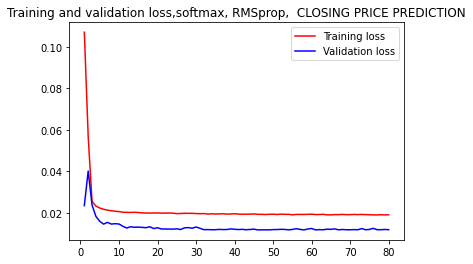

In [ ]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs1, loss1, 'r', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss,softmax, RMSprop,  CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

In [ ]:
history2 = model1.fit(train_gen2,
  steps_per_epoch=400,
  epochs=80,
  validation_data=val_gen2,
  validation_steps=val_steps2)

Epoch 1/80
400/400 [==============================] - 21s 53ms/step - loss: 0.0173 - val_loss: 0.0054
Epoch 2/80
400/400 [==============================] - 22s 56ms/step - loss: 0.0174 - val_loss: 0.0083
Epoch 3/80
400/400 [==============================] - 22s 55ms/step - loss: 0.0172 - val_loss: 0.0096
Epoch 4/80
400/400 [==============================] - 25s 62ms/step - loss: 0.0171 - val_loss: 0.0057
Epoch 5/80
400/400 [==============================] - 23s 58ms/step - loss: 0.0172 - val_loss: 0.0059
Epoch 6/80
400/400 [==============================] - 22s 54ms/step - loss: 0.0172 - val_loss: 0.0078
Epoch 7/80
400/400 [==============================] - 23s 57ms/step - loss: 0.0170 - val_loss: 0.0067
Epoch 8/80
400/400 [==============================] - 22s 55ms/step - loss: 0.0171 - val_loss: 0.0059
Epoch 9/80
400/400 [==============================] - 22s 54ms/step - loss: 0.0171 - val_loss: 0.0103
Epoch 10/80
400/400 [==============================] - 22s 56ms/step - loss: 0.017

In [ ]:
eval2 = model1.evaluate(test_gen2, steps = test_steps2)

190/190 [==============================] - 5s 25ms/step - loss: 0.0213


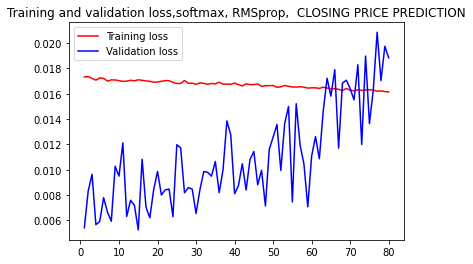

In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.figure()
plt.plot(epochs2, loss2, 'r', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss,softmax, RMSprop,  CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

In [ ]:
history3 = model1.fit(train_gen3,
  steps_per_epoch=400,
  epochs=80,
  validation_data=val_gen3,
  validation_steps=val_steps3)

Epoch 1/80
400/400 [==============================] - 23s 57ms/step - loss: 0.0163 - val_loss: 0.0178
Epoch 2/80
400/400 [==============================] - 22s 56ms/step - loss: 0.0160 - val_loss: 0.0251
Epoch 3/80
400/400 [==============================] - 21s 53ms/step - loss: 0.0159 - val_loss: 0.0244
Epoch 4/80
400/400 [==============================] - 23s 58ms/step - loss: 0.0158 - val_loss: 0.0291
Epoch 5/80
400/400 [==============================] - 22s 54ms/step - loss: 0.0157 - val_loss: 0.0303
Epoch 6/80
400/400 [==============================] - 23s 56ms/step - loss: 0.0158 - val_loss: 0.0317
Epoch 7/80
400/400 [==============================] - 22s 54ms/step - loss: 0.0158 - val_loss: 0.0248
Epoch 8/80
400/400 [==============================] - 22s 54ms/step - loss: 0.0157 - val_loss: 0.0322
Epoch 9/80
400/400 [==============================] - 22s 55ms/step - loss: 0.0156 - val_loss: 0.0320
Epoch 10/80
400/400 [==============================] - 21s 53ms/step - loss: 0.015

In [ ]:
eval3 = model1.evaluate(test_gen3, steps = test_steps3)

190/190 [==============================] - 2s 12ms/step - loss: 0.0254


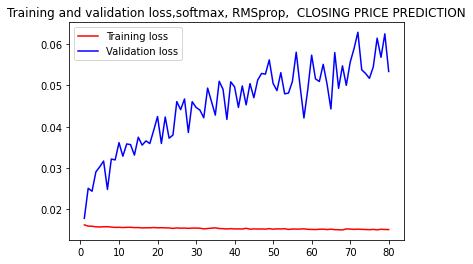

In [ ]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs3 = range(1, len(loss3) + 1)
plt.figure()
plt.plot(epochs3, loss3, 'r', label='Training loss')
plt.plot(epochs3, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss,softmax, RMSprop,  CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

Doesn't work, even not whole data is used, maybe divide into 3 parts and train separately?
